## assignment 04: Decision Tree construction

In [ ]:
# If working in colab, uncomment the following line
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/assignment0_04_tree/tree.py -nc

In [190]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's fix the `random_state` (a.k.a. random seed).

In [191]:
RANDOM_STATE = 42

In [192]:
arr = np.array([[0, 1, 2], [-1, 3, -2], [5, 3, -2], [0, 4, 3]])
arr[np.array([False, True, True, False])]

array([[-1,  3, -2],
       [ 5,  3, -2]])

In [193]:
ind_arr = np.array([1, 1, 1, 2, 2, 2, 1, 3, 3])
np.nonzero(ind_arr - np.roll(ind_arr, -1))

(array([2, 5, 6, 8]),)

In [194]:
np.unique(np.array([8, 7, 5, 4, 3, 2, 4]))

array([2, 3, 4, 5, 7, 8])

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

__Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

    
__Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


**Hints and comments**:

* No need to deal with categorical features, they will not be present.
* Siple greedy recursive procedure is enough. However, you can speed it up somehow (e.g. using percentiles).
* Please, do not copy implementations available online. You are supposed to build very simple example of the Decision Tree.

File `tree.py` is waiting for you. Implement all the needed methods in that file.

### Check yourself

In [195]:
from tree import entropy, gini, variance, mad_median, DecisionTree, get_freq_elem

#### Simple check

In [196]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

#### Classification problem

In [197]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [198]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [199]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8611111111111112


In [200]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [201]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8861111111111111


In [204]:
assert  0.84 < accuracy_gini < 0.9
assert  0.86 < accuracy_entropy < 0.9
assert np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-1

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [172]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [173]:
%%time
gs.fit(X_train, y_train)

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 39
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 118
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 35
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 119
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 39
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 212
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 294
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 150
  0%|          | 0/64

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 10
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 40
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 11
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 122
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 39
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 158
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 506
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 263
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 32
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 11
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 36
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 127
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 152
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 132
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 85
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 597
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 39
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 14
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 35
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 10
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 117
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 150
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 145
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 94
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 585
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 33
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 118
  0%|          | 0/

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 39
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 117
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 35
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Ge

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 24
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 82
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 10
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 117
Get_freq_elem arr length: 1
G

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 14
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 106
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 72
Get_freq_elem arr length: 1
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 88
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_ele

 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 65
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 39
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
G

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 41
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 84
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 81
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 14
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 25
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 60
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 13
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 24
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 66
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 109
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 23
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 24
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 82
 

Get_freq_elem arr length: 11
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 9
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 56
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 23
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 69
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 64
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 75
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 138
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 182
  0%|      

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 23
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 76
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 90
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 117
 

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 114
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 13
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 106
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 63
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 67
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 16
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 60
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 117
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 67

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 104
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 54
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 42
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 52
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 24
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 26
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 78
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
  0%|          | 0/64 [00:00<?, ?it/s

Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 43
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 68
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 13
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 37
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 33
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 58
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 82
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 81
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 27
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem a

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 114
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 13
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 106
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 17
  0%|          | 0/64 [00:00<?, ?it/s]


  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 29
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 62
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 110
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 18
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 27
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 24
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|     

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 8
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 27
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 51
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 25
  0%|         

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 32
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 36
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 55
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 15
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 84
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_ele

Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 77
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 11
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 19
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 10
Get_freq_elem

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 109


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 5


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 30


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 77


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 7


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 12


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 24
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 7
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 72


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 31


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 14


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 5


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 77


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


Exception ignored in: <function tqdm.__del__ at 0x7f879d3c5700>
Traceback (most recent call last):
  File "/home/eduard/anaconda3/envs/python/lib/python3.9/site-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/home/eduard/anaconda3/envs/python/lib/python3.9/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 16


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 8
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 34


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 81
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 23


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 5


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 7


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 140


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 16
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 132


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 8


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 16


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 10
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 4
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 96


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 14
Get_freq_elem arr length: 1


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 40


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 41


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 3
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 6


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 2
Get_freq_elem arr length: 2


  0%|          | 0/64 [00:00<?, ?it/s]

Get_freq_elem arr length: 67
CPU times: user 36.1 s, sys: 755 ms, total: 36.8 s
Wall time: 22min 10s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 11)},
             scoring='accuracy')

Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 27
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 53
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 10
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 7
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 61
  0%|        

  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 2
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 55
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
Get_freq_elem arr length: 2
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 3
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 77
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 4
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 5
  0%|          | 0/64 [00:00<?, ?it/s]
Get_freq_elem arr length: 6
Get_freq_elem arr length: 1
  0%|          | 0/64 [00:00<?, ?it/s]
Get_

In [174]:
gs.best_params_

{'criterion_name': 'entropy', 'max_depth': 8}

In [175]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

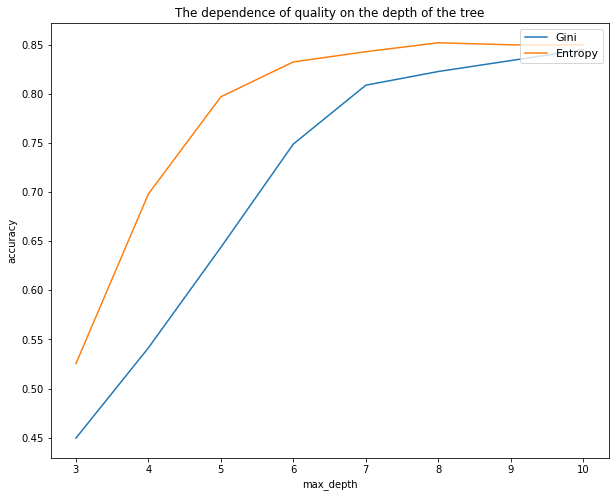

In [176]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

#### Regression problem

In [177]:
regr_data = load_boston().data
regr_target = load_boston().target[:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

In [178]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

17.352769607843136


In [179]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

10.724063912477718


In [180]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

In [181]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [182]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


In [183]:
gs_R.best_params_

{'criterion_name': 'mad_median', 'max_depth': 5}

In [184]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

In [185]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

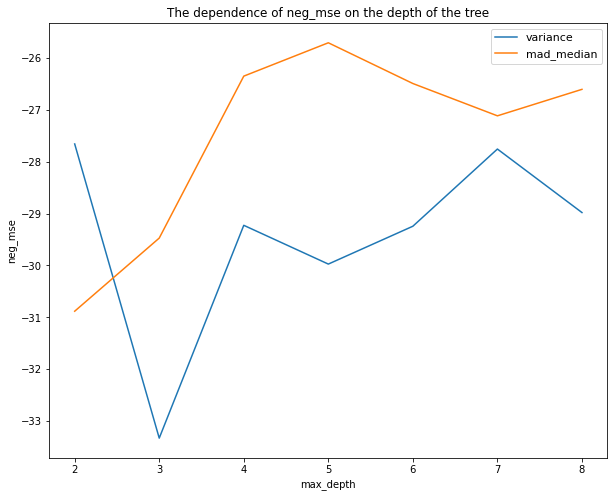

In [186]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()